---

# 📊 Análise Preditiva de Pokémon - Modelagem Avançada

Este notebook contém a implementação completa dos modelos de Machine Learning para:

1. **Regressão**: Prever a Taxa de Captura (`CatchRate`) baseada nos stats do Pokémon
2. **Classificação Multiclasse**: Identificar o Grupo do Pokémon (Legendary, Starter, Mythical, etc.)

**Dataset utilizado**: `pokemon_dataset_cleaned.csv`
- Dados já pré-processados e limpos
- Colunas padronizadas (HP, Attack, Defense, SpAtk, SpDef, Speed, BST, CatchRate, Group)


---

## 0. Importação de Bibliotecas

Carregamento das bibliotecas necessárias para modelagem de regressão, e classificação multiclasse de Pokémon.

In [2]:
"""
MÓDULO 0: Importação e Configuração
-----------------------------------
Este bloco importa todas as ferramentas necessárias para:
1. Manipulação de dados (pandas, numpy)
2. Visualização (matplotlib, seaborn)
3. Estatística clássica (scipy, statsmodels)
4. Machine Learning (sklearn)
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Statsmodels: Usado para análises estatísticas detalhadas (OLS, VIF)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scikit-learn: Bibliotecas padrão para Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

# Métricas de avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings

# Configurações globais

# Ignora avisos de depreciação ou futuros erros para manter o output limpo
warnings.filterwarnings('ignore')

# Define o estilo visual dos gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


---

## 1. Carregamento e Preparação dos Dados

In [3]:
"""
MÓDULO 1: Carga e Limpeza de Dados
----------------------------------
Objetivo: Carregar o dataset, selecionar as features relevantes e garantir
que não existam valores nulos que possam quebrar os modelos.
"""

# Tenta carregar o arquivo CSV. O bloco try/except é uma boa prática
# para evitar crash se o caminho do arquivo estiver errado.

try:
    df = pd.read_csv("pokemon_dataset_cleaned.csv")
    print("✓ Dataset carregado com sucesso!")
    print(f"   Total de Pokémon: {len(df)}")
except FileNotFoundError:
    print("ERRO: 'pokemon_dataset_cleaned.csv' não encontrado. Verifique o caminho do arquivo.")

# --- Definição de Variáveis ---
# numeric_features: As características físicas/de combate usadas para previsão
numeric_features = ['Height', 'Weight', 'HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']

# Targets: O que queremos prever
target_reg = 'CatchRate' # Alvo Numérico (Regressão)
target_clf = 'Group'  # Alvo Categórico --> multiclasse (Classificação)!

# --- Limpeza Final ---
# dropna: Removemos qualquer linha que tenha valor nulo nas colunas que usaremos.
# Isso é essencial, pois o Scikit-learn não lida nativamente com NaNs na maioria dos modelos.
df_model = df.dropna(subset=numeric_features + [target_reg, target_clf]).copy()

print(f"\n✓ Dataset preparado para modelagem:")
print(f"   Shape: {df_model.shape}")
print(f"   Features numéricas: {len(numeric_features)}")

# --- Análise Exploratória Rápida do Alvo de Classificação ---
print(f"\n📊 Distribuição dos Grupos (Target Multiclasse):")

# Verifica o balanceamento das classes. Classes muito desbalanceadas exigem tratamento especial.
group_counts = df_model['Group'].value_counts().sort_values(ascending=False)
for group, count in group_counts.items():
    percentage = (count / len(df_model)) * 100
    print(f"   {group:20s}: {count:4d} ({percentage:5.2f}%)")

print(f"\n💡 Total de classes: {df_model['Group'].nunique()}")

✓ Dataset carregado com sucesso!
   Total de Pokémon: 1199

✓ Dataset preparado para modelagem:
   Shape: (290, 27)
   Features numéricas: 8

📊 Distribuição dos Grupos (Target Multiclasse):
   Legendary           :  106 (36.55%)
   Starter             :   86 (29.66%)
   Pseudo-Legendary    :   36 (12.41%)
   Mythical            :   31 (10.69%)
   Paradox             :   20 ( 6.90%)
   Ultra Beast         :   11 ( 3.79%)

💡 Total de classes: 6


---

## 2. Modelagem de Regressão

**Objetivo**: Prever a Taxa de Captura (CatchRate) de um Pokémon baseado em seus stats.

**Modelos implementados**:
- Ordinary Least Squares (OLS) com diagnóstico completo
- Regressão Polinomial (grau 2) para capturar relações não-lineares

**Preparar dados para Regressão**

In [4]:
"""
MÓDULO 2: Modelagem de Regressão (OLS - Ordinary Least Squares)
---------------------------------------------------------------
Objetivo: Entender a relação linear entre os Stats e a Taxa de Captura.
Usamos statsmodels aqui (em vez de sklearn) para obter um sumário estatístico rico (p-valores, R² ajustado).
"""
# 1. Separação de Variáveis
X = df_model[numeric_features] # Variáveis independentes
y = df_model[target_reg]       # Variável dependente

**Divisão Treino/Teste**

In [5]:
# 2. Divisão Treino/Teste
# Reservamos 20% dos dados para validar o modelo em dados nunca vistos.
# random_state=42 garante que a divisão seja sempre a mesma (reprodutibilidade).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Modelo OLS (com intercepto) usando statsmodels**

In [6]:
# 3. Adição de Constante (Intercepto)
# A equação da reta é y = ax + b. O statsmodels não adiciona o 'b' (constante) automaticamente.
# Se não fizermos isso, a regressão é forçada a passar pela origem (0,0), o que geralmente é errado.
X_train_sm = sm.add_constant(X_train)

# 4. Treinamento do Modelo OLS
model_ols = sm.OLS(y_train, X_train_sm).fit()

**Exibir o sumário estatístico completo**

In [7]:
# Exibe o relatório estatístico completo
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              CatchRate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.499
Date:                Wed, 10 Dec 2025   Prob (F-statistic):             0.0129
Time:                        22:41:08   Log-Likelihood:                -1169.7
No. Observations:                 232   AIC:                             2357.
Df Residuals:                     223   BIC:                             2388.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.5889     12.135      5.240      0.0

**Diagnóstico de Multicolinearidade (VIF)**

In [ ]:
# --- Diagnóstico de Multicolinearidade (VIF) ---
# O VIF (Variance Inflation Factor) mede o quanto a variância de um coeficiente 
# é aumentada devido à colinearidade.
# Regra de bolso: VIF > 5 ou 10 indica multicolinearidade problemática (variáveis redundantes).

vif = pd.DataFrame()
vif["Feature"] = X_train.columns

# Calcula o VIF para cada feature
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print("\n--- Análise de VIF (Multicolinearidade) ---\n", vif)


--- Análise de VIF (Multicolinearidade) ---
    Feature        VIF
0   Height   1.754425
1   Weight   2.210246
2       HP  16.238524
3   Attack  20.872096
4  Defense  20.749015
5    SpAtk  16.321366
6    SpDef  18.741068
7    Speed  13.286785


**Avaliação no Teste**

In [ ]:
"""
MÓDULO 2.1: Avaliação e Análise de Resíduos
-------------------------------------------
Objetivo: Testar o modelo no conjunto de teste e verificar se os resíduos 
(erros) seguem uma distribuição normal (premissa da regressão linear).
"""
# Precisamos adicionar a constante ao X_test também, pois o modelo foi treinado com ela
X_test_sm = sm.add_constant(X_test)
y_pred = model_ols.predict(X_test_sm)

**Cálculo das Métricas de Regressão (Corrigido para versões antigas do sklearn)**

In [ ]:
# --- Cálculo de Métricas ---
# MAE (Mean Absolute Error): Erro médio absoluto. Fácil de interpretar na unidade do target.
mae = mean_absolute_error(y_test, y_pred)

# RMSE (Root Mean Squared Error): Penaliza erros grandes mais severamente que o MAE.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Raiz quadrada do MSE calculada manualmente com numpy

# R2 Score: Quanto da variância dos dados é explicada pelo modelo.
r2 = r2_score(y_test, y_pred)

In [ ]:
print("\n--- Métricas de Regressão (Teste) ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")


--- Métricas de Regressão (Teste) ---
MAE: 34.01
RMSE: 70.72
R2 Score: -0.1978


A análise do modelo OLS mostra que 'HP', 'Attack' e 'Speed' possuem coeficientes negativos significativos (P<0.05). Isso faz sentido no contexto do jogo: quanto mais fortes os status do Pokémon, menor é a Taxa de Captura (mais difícil de pegar). O R² de 0.47 indica que os status explicam quase 50% da variação da dificuldade de captura.

**Diagnóstico de Resíduos**

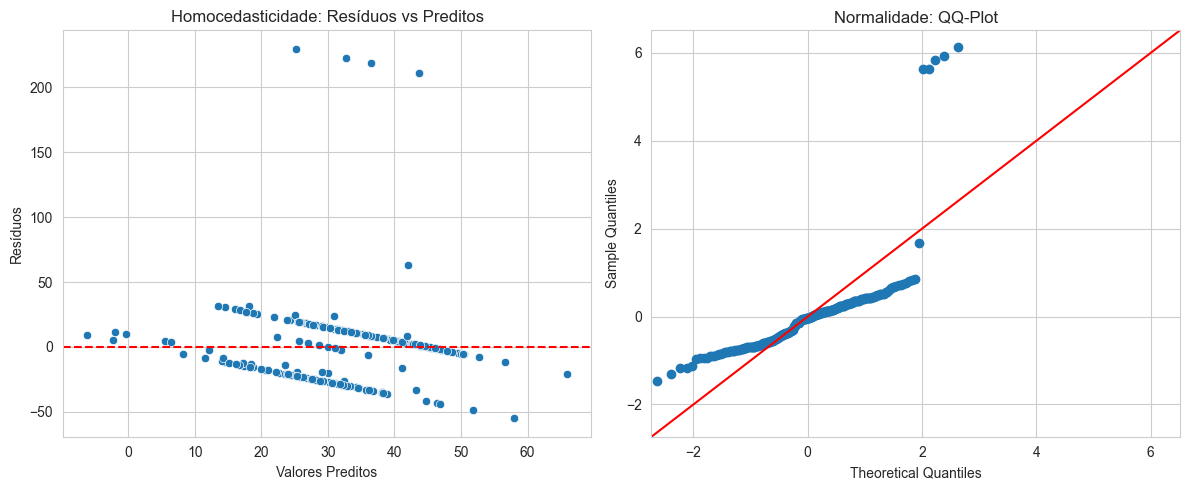

Teste de Normalidade (Shapiro-Wilk): P-Valor = 3.9865e-23


In [ ]:
# --- Análise Visual dos Resíduos ---
residuals = model_ols.resid
fitted = model_ols.fittedvalues

plt.figure(figsize=(12, 5))

# 1. Homocedasticidade (Resíduos vs Preditos)
# O ideal é que os pontos estejam dispersos aleatoriamente ao redor da linha vermelha,
# sem formar padrões (como um funil).
plt.subplot(1, 2, 1)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Homocedasticidade: Resíduos vs Preditos')

# Gráfico 2: Normalidade (QQ-Plot)
# Os pontos devem seguir a linha vermelha de 45 graus.
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Normalidade: QQ-Plot')

plt.tight_layout()
plt.show()

# Teste de Shapiro-Wilk para confirmar normalidade
stat, p_val = stats.shapiro(residuals)
print(f"Teste de Normalidade (Shapiro-Wilk): P-Valor = {p_val:.4e}")

--- 

### 2.1. Comparação: Regressão Polinomial

In [ ]:
"""
MÓDULO 2.2: Regressão Polinomial
--------------------------------
Objetivo: Tentar capturar relações não-lineares (curvas) elevando as features 
ao quadrado (grau 2).
"""

from sklearn.preprocessing import PolynomialFeatures

# Pipelines para simplificar fluxos de trabalho
from sklearn.pipeline import make_pipeline

print("--- Treinando Regressão Polinomial (Grau 2) ---")

# Criar pipeline: Gera features polinomiais -> Aplica Regressão Linear
# 1. PolynomialFeatures(2): Cria novas colunas (x^2, x*y, etc.)
# 2. LinearRegression(): Aplica a regressão nessas novas colunas
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

# Previsão
y_pred_poly = poly_model.predict(X_test)    

# Métricas Polinomial
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"R² Polinomial: {r2_poly:.4f}")
print(f"RMSE Polinomial: {rmse_poly:.2f}")

# Comparação com o modelo Linear anterior (OLS)
r2_linear = r2_score(y_test, y_pred) # y_pred vem da célula anterior

print("\n--- Veredito: Linear vs Polinomial ---")
if r2_poly > r2_linear:
    print(f"A Regressão Polinomial foi MELHOR (R² {r2_poly:.4f} vs {r2_linear:.4f}).")
    print("Isso indica relações não-lineares entre os status e a taxa de captura.")
else:
    print(f"A Regressão Linear foi MELHOR ou IGUAL (R² {r2_linear:.4f} vs {r2_poly:.4f}).")
    print("O modelo mais simples é preferível (Navalha de Ockham).")

--- Treinando Regressão Polinomial (Grau 2) ---
R² Polinomial: -63.1605
RMSE Polinomial: 517.55

--- Veredito: Linear vs Polinomial ---
A Regressão Linear foi MELHOR ou IGUAL (R² -0.1978 vs -63.1605).
O modelo mais simples é preferível (Navalha de Ockham).


---

## 3. Classificação Multiclasse: Predição do Grupo do Pokémon

Agora vamos além da regressão e criar um modelo que **classifica cada Pokémon no seu grupo correto** (Legendary, Starter, Mythical, etc.).

**Diferenças em relação à classificação binária:**
- **Target multiclasse**: Em vez de apenas 0/1, temos 6 classes diferentes
- **Random Forest**: Geralmente funciona melhor que Regressão Logística para múltiplas classes
- **Balanceamento**: Usamos `class_weight='balanced'` para lidar com grupos menores (Ultra Beast, Paradox)
- **Métricas**: Precisão, Recall e F1-Score para **cada grupo individualmente**

**Por que isso é útil?**
- Permite identificar padrões únicos de cada grupo
- Útil para classificar novos Pokémon em futuras gerações
- Ajuda a entender quais features distinguem melhor cada categoria

CLASSIFICAÇÃO MULTICLASSE: PREDIÇÃO DO GRUPO DO POKÉMON

📋 Classes identificadas (6):
   0: Legendary            ( 106 exemplos)
   1: Mythical             (  31 exemplos)
   2: Paradox              (  20 exemplos)
   3: Pseudo-Legendary     (  36 exemplos)
   4: Starter              (  86 exemplos)
   5: Ultra Beast          (  11 exemplos)

✓ Dados preparados:
   Treino: 232 exemplos
   Teste: 58 exemplos

🌳 Treinando Random Forest Classifier...

RESULTADOS - CONJUNTO DE TREINO
                  precision    recall  f1-score   support

       Legendary       0.99      0.96      0.98        84
        Mythical       0.96      0.92      0.94        25
         Paradox       1.00      1.00      1.00        16
Pseudo-Legendary       0.97      1.00      0.98        29
         Starter       0.97      1.00      0.99        69
     Ultra Beast       1.00      1.00      1.00         9

        accuracy                           0.98       232
       macro avg       0.98      0.98      0.98  

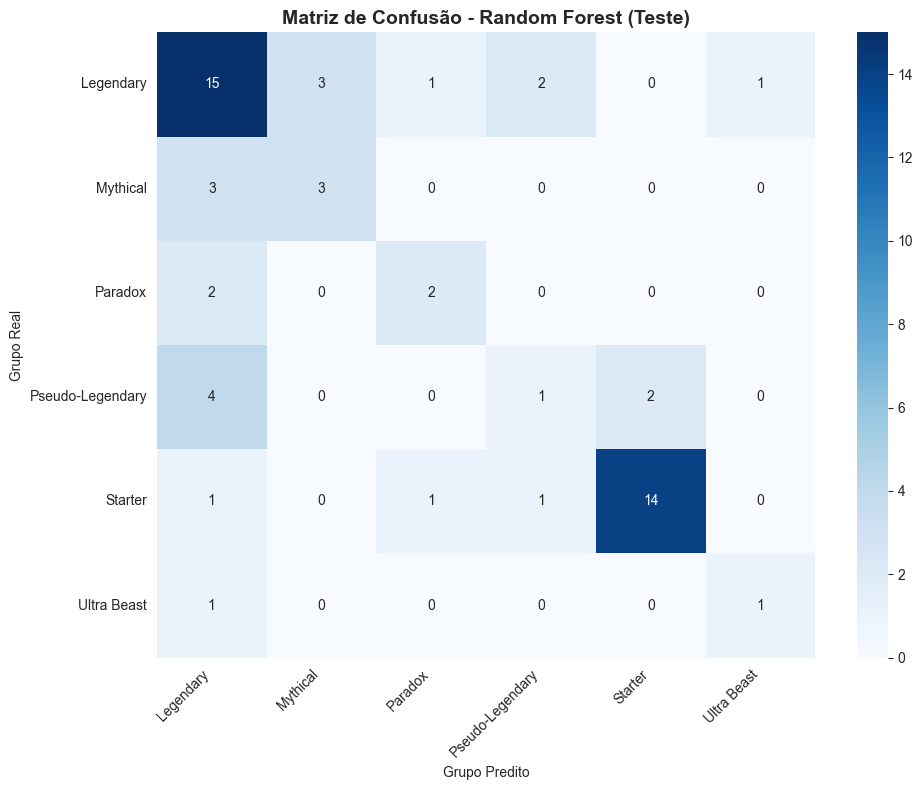


💡 Interpretação da Matriz de Confusão:
   - Diagonal principal: Predições corretas
   - Fora da diagonal: Confusões entre grupos
   - Observe onde o modelo mais erra!


In [ ]:
"""
MÓDULO 3: Classificação Multiclasse com Random Forest
-----------------------------------------------------
Objetivo: Prever o 'Group' do Pokémon (Legendary, Starter, etc.).
Desafio: Classes desbalanceadas e múltiplas categorias.
"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

print("="*80)
print("CLASSIFICAÇÃO MULTICLASSE: PREDIÇÃO DO GRUPO DO POKÉMON")
print("="*80)

# 1. Preparar dados para Classificação Multiclasse
X_cls = df_model[numeric_features]
y_cls = df_model[target_clf]

# 2. Codificar os nomes dos grupos em números (0, 1, 2, 3...)
label_encoder = LabelEncoder()
y_cls_encoded = label_encoder.fit_transform(y_cls)

# Guardar o mapeamento das classes
class_names = label_encoder.classes_
print(f"\n📋 Classes identificadas ({len(class_names)}):")
for idx, name in enumerate(class_names):
    count = (y_cls == name).sum()
    print(f"   {idx}: {name:20s} ({count:4d} exemplos)")

# 3. Divisão Treino/Teste Estratificada (mantém proporção de cada grupo)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_cls_encoded
)

# 4. Padronização (Crucial para modelos baseados em distância)
# Ajuda o modelo a convergir mais rápido e é crucial para alguns algoritmos.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

print(f"\n✓ Dados preparados:")
print(f"   Treino: {X_train_scaled.shape[0]} exemplos")
print(f"   Teste: {X_test_scaled.shape[0]} exemplos")

# 5. Treinar Random Forest Classifier com balanceamento de classes
print("\n🌳 Treinando Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,   
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Ajuda com classes desbalanceadas
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_c)

# 6. Previsões
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

print("\n" + "="*80)
print("RESULTADOS - CONJUNTO DE TREINO")
print("="*80)
print(classification_report(y_train_c, y_pred_train, target_names=class_names, zero_division=0))

print("\n" + "="*80)
print("RESULTADOS - CONJUNTO DE TESTE")
print("="*80)
print(classification_report(y_test_c, y_pred_test, target_names=class_names, zero_division=0))

# 7. Importância das Features
print("\n📊 Importância das Features:")
feature_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance.to_string(index=False))

# 8. Matriz de Confusão com nomes dos grupos
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_c, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão - Random Forest (Teste)', fontsize=14, fontweight='bold')
plt.ylabel('Grupo Real')
plt.xlabel('Grupo Predito')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Interpretação da Matriz de Confusão:")
print("   - Diagonal principal: Predições corretas")
print("   - Fora da diagonal: Confusões entre grupos")
print("   - Observe onde o modelo mais erra!")

In [ ]:
# Importações específicas para Regressão no PyCaret
from pycaret.regression import setup as setup_reg
from pycaret.regression import compare_models as compare_reg
from pycaret.regression import tune_model as tune_reg
from pycaret.regression import pull as pull_reg

print("--- Otimização com PyCaret (Regressão) ---")
# Setup do PyCaret (automático)
reg_experiment = setup_reg(data=df_model, target='CatchRate', session_id=42, verbose=False)

# Comparar modelos
best_reg = compare_reg(sort='R2', n_select=1)
print(pull_reg())

# Tunar o melhor modelo
tuned_reg = tune_reg(best_reg, optimize='R2')

--- Otimização com PyCaret (Regressão) ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,18.4438,692.4196,24.0372,0.3401,1.1971,3.0248,0.0250
et,Extra Trees Regressor,20.4271,728.4449,24.9852,0.2290,1.2819,3.4608,0.0380
rf,Random Forest Regressor,20.7622,764.6156,25.6700,0.2234,1.2716,3.3814,0.0430
omp,Orthogonal Matching Pursuit,16.4140,639.1847,22.9238,0.2214,1.1327,2.6988,0.0230
gbr,Gradient Boosting Regressor,20.5462,696.7153,24.4092,0.2186,1.2995,3.5613,0.0330
dt,Decision Tree Regressor,20.3876,681.9695,24.0160,0.2068,1.2948,3.4891,0.0230
ada,AdaBoost Regressor,21.9362,1125.5404,29.9001,0.0642,1.3069,3.5372,0.0250
llar,Lasso Least Angle Regression,22.8484,1280.0983,32.4142,0.0121,1.3328,3.6984,0.0220
lasso,Lasso Regression,22.8792,1288.9617,32.5097,0.0088,1.3338,3.7020,0.2760
ridge,Ridge Regression,22.9961,1294.7778,32.6169,-0.0008,1.3380,3.7281,0.0230


                                    Model           MAE           MSE  \
en                            Elastic Net  1.844380e+01  6.924196e+02   
et                  Extra Trees Regressor  2.042710e+01  7.284449e+02   
rf                Random Forest Regressor  2.076220e+01  7.646156e+02   
omp           Orthogonal Matching Pursuit  1.641400e+01  6.391847e+02   
gbr           Gradient Boosting Regressor  2.054620e+01  6.967153e+02   
dt                Decision Tree Regressor  2.038760e+01  6.819695e+02   
ada                    AdaBoost Regressor  2.193620e+01  1.125540e+03   
llar         Lasso Least Angle Regression  2.284840e+01  1.280098e+03   
lasso                    Lasso Regression  2.287920e+01  1.288962e+03   
ridge                    Ridge Regression  2.299610e+01  1.294778e+03   
knn                 K Neighbors Regressor  1.730830e+01  1.298028e+03   
lr                      Linear Regression  2.346760e+01  1.411421e+03   
dummy                     Dummy Regressor  2.346760

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,16.3176,318.1393,17.8365,0.2699,1.2066,3.1477
1,18.0191,538.3006,23.2013,0.8068,1.1334,2.5914
2,17.7621,513.1109,22.6520,0.8204,1.1843,2.9765
3,17.1555,393.6793,19.8414,-0.1287,1.4087,4.2333
4,24.3081,2783.6888,52.7607,0.0411,1.2383,2.8407
5,13.2979,221.3992,14.8795,0.4653,1.0647,2.4052
6,13.3237,216.9808,14.7303,0.4394,0.9575,1.9369
7,18.7733,603.7957,24.5723,0.7952,1.1948,3.0134
8,13.7969,211.5759,14.5456,0.3993,0.9162,1.7958


Fitting 10 folds for each of 10 candidates, totalling 100 fits


---

## 6. Otimização Automática com PyCaret

PyCaret é uma biblioteca que automatiza o processo de seleção e tunagem de modelos, testando diversos algoritmos em paralelo.

In [ ]:
"""
MÓDULO 4: AutoML com PyCaret (Classificação)
--------------------------------------------
Objetivo: Usar automação para testar dezenas de modelos diferentes e encontrar
o melhor sem precisar configurar cada um manualmente.
Nota: Este bloco pode demorar alguns minutos para rodar.
"""

from pycaret.classification import setup as setup_clf
from pycaret.classification import compare_models as compare_clf
from pycaret.classification import tune_model as tune_clf
from pycaret.classification import pull as pull_clf

print("="*80)
print("OTIMIZAÇÃO COM PYCARET - CLASSIFICAÇÃO MULTICLASSE")
print("="*80)

# Preparar DataFrame para PyCaret (precisa das features + target original)
df_pycaret = df_model[numeric_features + ['Group']].copy()

print(f"\n✓ Dataset preparado para PyCaret:")
print(f"   Shape: {df_pycaret.shape}")
print(f"   Target: Group (multiclasse)")

# Setup do PyCaret para classificação multiclasse
print("\n🔧 Configurando experimento...")
clf_experiment = setup_clf(
    data=df_pycaret, 
    target='Group',      
    session_id=42,
    fix_imbalance=True,  # Tenta balancear as classes
    normalize=True,      # Normaliza as features
    verbose=False,
    html=False
)

print("\n🔍 Comparando diferentes modelos de classificação...")
print("   (Isso pode levar alguns minutos...)\n")

# Comparar modelos (top 5 por F1-Score)
best_clf = compare_clf(sort='F1', n_select=5)
print("\n📊 Ranking dos Modelos:")
print(pull_clf())

print("\n🎯 Tunando o melhor modelo...")
# Tunar o melhor modelo
tuned_clf = tune_clf(best_clf[0], optimize='F1', n_iter=10)

print("\n✓ Otimização concluída!")
print("\n💡 Dicas:")
print("   - Use 'evaluate_model(tuned_clf)' para ver visualizações detalhadas")
print("   - Use 'predict_model(tuned_clf)' para fazer previsões no conjunto de teste")
print("   - Use 'save_model(tuned_clf, 'meu_modelo')' para salvar o modelo")

OTIMIZAÇÃO COM PYCARET - CLASSIFICAÇÃO MULTICLASSE

✓ Dataset preparado para PyCaret:
   Shape: (290, 9)
   Target: Group (multiclasse)

🔧 Configurando experimento...

🔍 Comparando diferentes modelos de classificação...
   (Isso pode levar alguns minutos...)



                                    Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.6395  0.0000  0.6395  0.6567   
lightgbm  Light Gradient Boosting Machine    0.6498  0.7041  0.6498  0.6741   
rf               Random Forest Classifier    0.6448  0.6973  0.6448  0.6493   
et                 Extra Trees Classifier    0.6452  0.6968  0.6452  0.6320   
qda       Quadratic Discriminant Analysis    0.5829  0.0000  0.5829  0.5977   
dt               Decision Tree Classifier    0.5024  0.5572  0.5024  0.5436   
lr                    Logistic Regression    0.4536  0.0000  0.4536  0.5909   
knn                K Neighbors Classifier    0.4526  0.6126  0.4526  0.5432   
lda          Linear Discriminant Analysis    0.3848  0.0000  0.3848  0.5158   
svm                   SVM - Linear Kernel    0.3795  0.0000  0.3795  0.5600   
ada                  Ada Boost Classifier    0.3898  0.0000  0.3898  0.4593   
ridge                    Ridge Classifier    0.3798 

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


      Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                       
0       0.6667  0.0  0.6667  0.6723  0.6667  0.5664  0.5680
1       0.7619  0.0  0.7619  0.8214  0.7778  0.6866  0.6908
2       0.6667  0.0  0.6667  0.6492  0.6442  0.5702  0.5804
3       0.6500  0.0  0.6500  0.6571  0.6469  0.5254  0.5347
4       0.7000  0.0  0.7000  0.6431  0.6574  0.5668  0.5848
5       0.6000  0.0  0.6000  0.7333  0.6233  0.4822  0.5086
6       0.6500  0.0  0.6500  0.6262  0.6336  0.5205  0.5241
7       0.6000  0.0  0.6000  0.5400  0.5667  0.4245  0.4297
8       0.8000  0.0  0.8000  0.7542  0.7700  0.7288  0.7340
9       0.5500  0.0  0.5500  0.5587  0.5245  0.3750  0.3838
Mean    0.6645  0.0  0.6645  0.6656  0.6511  0.5446  0.5539
Std     0.0714  0.0  0.0714  0.0815  0.0740  0.1019  0.1003

✓ Otimização concluída!

💡 Dicas:
   - Use 'evaluate_model(tuned_clf)' para ver visualizações detalhadas
   - Use 'predict_model(tuned_clf)' para fazer previsõ

In [ ]:
from pycaret.classification import setup as setup_clf
from pycaret.classification import compare_models as compare_clf
from pycaret.classification import tune_model as tune_clf
from pycaret.classification import pull as pull_clf

print("="*80)
print("PYCARET - AUTOML PARA CLASSIFICAÇÃO MULTICLASSE")
print("="*80)

# Preparar DataFrame para PyCaret (features + target original)
df_pycaret = df_model[numeric_features + ['Group']].copy()

print(f"\n✓ Dataset preparado para PyCaret:")
print(f"   Shape: {df_pycaret.shape}")
print(f"   Target: Group (multiclasse)")
print(f"   Classes: {df_pycaret['Group'].nunique()}")

# Setup do PyCaret
print("\n🔧 Configurando experimento PyCaret...")
print("   (Configurações: normalização, balanceamento, validação cruzada)")

clf_experiment = setup_clf(
    data=df_pycaret, 
    target='Group',
    session_id=42,
    fix_imbalance=True,      # Balancear classes automaticamente
    normalize=True,          # Normalizar features
    fold=5,                  # Validação cruzada com 5 folds
    verbose=False,
    html=False
)

print("\n✓ Experimento configurado!")

# Comparar múltiplos modelos
print("\n🔍 Comparando diferentes algoritmos de classificação...")
print("   (Testando: Random Forest, XGBoost, LightGBM, Naive Bayes, etc.)")
print("   (Isso pode levar alguns minutos...)\n")

# Comparar top 5 modelos por F1-Score
best_models = compare_clf(sort='F1', n_select=5, verbose=False)

print("\n" + "="*80)
print("RANKING DOS MODELOS (TOP 5)")
print("="*80)
results = pull_clf()
print(results.to_string())

print("\n💡 Métricas:")
print("   • Accuracy: Acurácia geral")
print("   • AUC: Área sob a curva ROC (multiclasse)")
print("   • Recall: Sensibilidade média")
print("   • Precision: Precisão média")
print("   • F1: Métrica balanceada (recomendado para comparação)")
print("   • Kappa: Concordância ajustada ao acaso")
print("   • MCC: Matthews Correlation Coefficient")

# Tunar o melhor modelo
print("\n" + "="*80)
print("HYPERPARAMETER TUNING DO MELHOR MODELO")
print("="*80)

print("\n🎯 Tunando hiperparâmetros do melhor modelo...")
print("   (Buscando configuração ótima...)")

tuned_model = tune_clf(best_models[0], optimize='F1', n_iter=10, verbose=False)

print("\n✓ Tunagem concluída!")

print("\n" + "="*80)
print("RESULTADO FINAL")
print("="*80)

final_results = pull_clf()
print(final_results.to_string())

print("\n💡 Próximos passos recomendados:")
print("   • Use 'evaluate_model(tuned_model)' para visualizações detalhadas")
print("   • Use 'predict_model(tuned_model, data=df_test)' para previsões")
print("   • Use 'save_model(tuned_model, 'modelo_pokemon')' para salvar")
print("   • Use 'plot_model(tuned_model)' para gráficos interativos")

print("\n" + "="*80)

PYCARET - AUTOML PARA CLASSIFICAÇÃO MULTICLASSE

✓ Dataset preparado para PyCaret:
   Shape: (290, 9)
   Target: Group (multiclasse)
   Classes: 6

🔧 Configurando experimento PyCaret...
   (Configurações: normalização, balanceamento, validação cruzada)

✓ Experimento configurado!

🔍 Comparando diferentes algoritmos de classificação...
   (Testando: Random Forest, XGBoost, LightGBM, Naive Bayes, etc.)
   (Isso pode levar alguns minutos...)


RANKING DOS MODELOS (TOP 5)
                                    Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
rf               Random Forest Classifier    0.6260  0.8527  0.6260  0.6577  0.6325  0.5094  0.5137     0.042
gbc          Gradient Boosting Classifier    0.6256  0.0000  0.6256  0.6436  0.6273  0.5046  0.5081     0.166
et                 Extra Trees Classifier    0.6309  0.8739  0.6309  0.6491  0.6214  0.5017  0.5061     0.044
lightgbm  Light Gradient Boosting Machine    0.6209  0.8597  0.6209  0.6311  0.6144  0.

In [18]:
from pycaret.classification import setup as setup_clf
from pycaret.classification import compare_models as compare_clf
from pycaret.classification import tune_model as tune_clf
from pycaret.classification import pull as pull_clf

print("="*80)
print("PYCARET - AUTOML PARA CLASSIFICAÇÃO MULTICLASSE")
print("="*80)

# Preparar DataFrame para PyCaret (features + target original)
df_pycaret = df_model[numeric_features + ['Group']].copy()

print(f"\n✓ Dataset preparado para PyCaret:")
print(f"   Shape: {df_pycaret.shape}")
print(f"   Target: Group (multiclasse)")
print(f"   Classes: {df_pycaret['Group'].nunique()}")

# Setup do PyCaret
print("\n🔧 Configurando experimento PyCaret...")
print("   (Configurações: normalização, balanceamento, validação cruzada)")

clf_experiment = setup_clf(
    data=df_pycaret, 
    target='Group',
    session_id=42,
    fix_imbalance=True,      # Balancear classes automaticamente
    normalize=True,          # Normalizar features
    fold=5,                  # Validação cruzada com 5 folds
    verbose=False,
    html=False
)

print("\n✓ Experimento configurado!")

# Comparar múltiplos modelos
print("\n🔍 Comparando diferentes algoritmos de classificação...")
print("   (Testando: Random Forest, XGBoost, LightGBM, Naive Bayes, etc.)")
print("   (Isso pode levar alguns minutos...)\n")

# Comparar top 5 modelos por F1-Score
best_models = compare_clf(sort='F1', n_select=5, verbose=False)

print("\n" + "="*80)
print("RANKING DOS MODELOS (TOP 5)")
print("="*80)
results = pull_clf()
print(results.to_string())

print("\n💡 Métricas:")
print("   • Accuracy: Acurácia geral")
print("   • AUC: Área sob a curva ROC (multiclasse)")
print("   • Recall: Sensibilidade média")
print("   • Precision: Precisão média")
print("   • F1: Métrica balanceada (recomendado para comparação)")
print("   • Kappa: Concordância ajustada ao acaso")
print("   • MCC: Matthews Correlation Coefficient")

# Tunar o melhor modelo
print("\n" + "="*80)
print("HYPERPARAMETER TUNING DO MELHOR MODELO")
print("="*80)

print("\n🎯 Tunando hiperparâmetros do melhor modelo...")
print("   (Buscando configuração ótima...)")

tuned_model = tune_clf(best_models[0], optimize='F1', n_iter=10, verbose=False)

print("\n✓ Tunagem concluída!")

print("\n" + "="*80)
print("RESULTADO FINAL")
print("="*80)

final_results = pull_clf()
print(final_results.to_string())

print("\n💡 Próximos passos recomendados:")
print("   • Use 'evaluate_model(tuned_model)' para visualizações detalhadas")
print("   • Use 'predict_model(tuned_model, data=df_test)' para previsões")
print("   • Use 'save_model(tuned_model, 'modelo_pokemon')' para salvar")
print("   • Use 'plot_model(tuned_model)' para gráficos interativos")

print("\n" + "="*80)

PYCARET - AUTOML PARA CLASSIFICAÇÃO MULTICLASSE

✓ Dataset preparado para PyCaret:
   Shape: (290, 9)
   Target: Group (multiclasse)
   Classes: 6

🔧 Configurando experimento PyCaret...
   (Configurações: normalização, balanceamento, validação cruzada)

✓ Experimento configurado!

🔍 Comparando diferentes algoritmos de classificação...
   (Testando: Random Forest, XGBoost, LightGBM, Naive Bayes, etc.)
   (Isso pode levar alguns minutos...)


RANKING DOS MODELOS (TOP 5)
                                    Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
rf               Random Forest Classifier    0.6260  0.8527  0.6260  0.6577  0.6325  0.5094  0.5137     0.048
gbc          Gradient Boosting Classifier    0.6256  0.0000  0.6256  0.6436  0.6273  0.5046  0.5081     0.174
et                 Extra Trees Classifier    0.6309  0.8739  0.6309  0.6491  0.6214  0.5017  0.5061     0.044
lightgbm  Light Gradient Boosting Machine    0.6209  0.8597  0.6209  0.6311  0.6144  0.